In [1]:
###This block only defines functions for creating the 2 NN's and their training 

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


###Creating a newtork with 2 hidden layers.. Creating 2 functions, 1st to initialize & 2nd to define activation functions
class Classifier(nn.Module):
   
    def __init__(self, width, n_inputs=2):
        super(Classifier, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(n_inputs, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer (Our NN output=1)
        self.output = nn.Linear(width, 1)
        
    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = torch.sigmoid(self.output(x))
    
        return x



###Training the NN.. Defining optimizer and learning rate..
def normal_training(generating_function, N_train=500):
    
    # determine the size of the classifier
    X, _, _ = generating_function(10)
    
    #~~~X.shape[1]= the second number specefying dimension of X ... Here it is always = 2 from the toy-generating fn
    n_inputs = X.shape[1]
    #~~~Create the network containing 10 neurons per layer.. (n_inputs = 2 & output = 1)
    clf = Classifier(10, n_inputs=n_inputs)
    
    optimiser = torch.optim.Adam(clf.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # track the losses
    clf_losses = []
    clf_losses_test = []

    for _ in range(N_train):

        # create the data
        X, Y, Z = generating_function(512)
        X = torch.as_tensor(X, dtype=torch.float)
        Y = torch.as_tensor(Y.reshape(-1, 1), dtype=torch.float)
        Z = torch.as_tensor(Z.reshape(-1, 1), dtype=torch.float)

        # make the training loss
        output = clf(X)
        loss = criterion(output, Y)
        clf_losses.append(loss.data.numpy().item())

        # backprop
        clf.zero_grad()
        loss.backward()
        optimiser.step()
        
        # test loss
        X_test, Y_test, _ = generating_function(512, train=False)
        X_test = torch.as_tensor(X_test, dtype=torch.float)
        Y_test = torch.as_tensor(Y_test.reshape(-1, 1), dtype=torch.float)
        output_test = clf(X_test)
        loss_test = criterion(output_test, Y_test)
        clf_losses_test.append(loss_test.data.numpy().item())
    
    print('Done with training')

    fig, ax = plt.subplots()
    ax.plot(range(len(clf_losses)), clf_losses, label='train loss')
    ax.plot(range(len(clf_losses_test)), clf_losses_test, label='test loss')
    ax.set_xlabel('Training step')
    ax.set_ylabel('Classifier loss')
    ax.legend(loc='best')
    plt.show()
    
    return clf
    
    
    
###Creating the adversarial NN
class Regressor(nn.Module):
    
    def __init__(self, width):
        super(Regressor, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(1, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer
        self.output = nn.Linear(width, 1)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = self.output(x)
    
        return x



###Training the adversarial NN
def adversarial_training(generating_function, N_train=200):
    
    # determine the size of the classifier
    X, _, _ = generating_function(10)
    print ("shape of tensor X is ",X.shape[1])
    n_inputs = X.shape[1]
    
    # create the classifier and the adversary networks
    clf = Classifier(10, n_inputs=n_inputs)
    adv = Regressor(10)

    # training settings
    learning_rate = 0.001
    lam = 10.0 # lambda tradeoff parameter

    # choose the criterions
    clf_criterion = nn.BCELoss()
    adv_criterion = nn.MSELoss()

    # create optimisers (larger learning rate for the adversary )
    clf_optimiser = torch.optim.Adam(clf.parameters(), lr=learning_rate)
    adv_optimiser = torch.optim.Adam(adv.parameters(), lr=5*learning_rate)

    # keep track of the losses
    clf_losses = []
    adv_losses = []
    clf_losses_test = []
    adv_losses_test = []

    # training loop
    for _ in range(N_train):

        # create the data
        X, Y, Z = generating_function(512)
        X = torch.as_tensor(X, dtype=torch.float)
        Y = torch.as_tensor(Y.reshape(-1, 1), dtype=torch.float)
        Z = torch.as_tensor(Z.reshape(-1, 1), dtype=torch.float)

        ##############################
        # Update the adversary network
        # (several updtes to keep up with
        # the changes in the classifier)
        ##############################
    
        M = 5
        for _ in range(M):
            # make the adversary loss
            clf_output = clf(X)
            adv_output = adv(clf_output)
            adv_loss = adv_criterion(adv_output, Z)
    
            # backprop: adapt the adversary to the classifier (only update the adversary weights)
            adv.zero_grad()
            adv_loss.backward()
            adv_optimiser.step()
            
        adv_losses.append(adv_loss.data.numpy().item())

        ##############################
        # Update the classifier network
        ##############################
    
        # forward pass
        clf_output = clf(X)
        adv_output = adv(clf_output)
    
        # make the losses: both the classifier and the adversary loss
        # combined loss: note the minus sign!
        # (when updating the classifier, the goal is to confuse the adversary)
        clf_loss = clf_criterion(clf_output, Y)
        adv_loss = adv_criterion(adv_output, Z)
        comb_loss = clf_loss - lam * adv_loss
            
        # backprop the classifier: update only the classifier weights (keep adversary intact)
        clf.zero_grad()
        comb_loss.backward()
        clf_optimiser.step()
            
        clf_losses.append(clf_loss.data.numpy().item())
    
        #######################
        # store the test losses
        #######################
        X_test, Y_test, _ = generating_function(512, train=False)
        X_test = torch.as_tensor(X_test, dtype=torch.float)
        Y_test = torch.as_tensor(Y_test.reshape(-1, 1), dtype=torch.float)
        output_test = clf(X_test)
        loss_test = clf_criterion(output_test, Y_test)
        clf_losses_test.append(loss_test.data.numpy().item())
    
    print('Done with training')

    fig, ax = plt.subplots(2, sharex=True)
    ax[0].plot(range(len(clf_losses)), clf_losses, label='train loss')
    ax[0].plot(range(len(clf_losses_test)), clf_losses_test, label='test loss')
    ax[0].set_ylabel('Classifier loss')
    ax[0].legend(loc='best')
    ax[1].plot(range(len(adv_losses)), adv_losses, color='k')
    ax[1].set_ylabel('Adversary loss')
    ax[1].set_xlabel('Training step')
    plt.show()
    
    return clf



In [2]:
###Function that generates data... I added the z-paramater (and the if condition) to use it for the "show_clf_output" function to draw an evaluation plot
def generate_hbb(n_samples, z=None , train=True):
    
    # test or train
    X_full = X_train if train else X_test
    Y_full = Y_train if train else Y_test
    Z_full = Z_train if train else Z_test

    # sample the events
    random_state = np.random.randint(0, 10000)
    X = X_full.sample(n_samples, random_state=random_state)
    Y = Y_full.sample(n_samples, random_state=random_state)
    if z==None:
        Z = Z_full.sample(n_samples, random_state=random_state)
        return X_pca.transform(X), Y.values, Z_pca.transform(Z)
    else:
        Z = z * np.ones((n_samples, 1))
        return X_pca.transform(X), Y.values, Z
    
    # preprocess them
    ##return X_pca.transform(X), Y.values, Z_pca.transform(Z)

In [8]:
###This block is dedicated to creating plots to evaluate the training of the NN

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.metrics import roc_curve

###I adjusted the 3 ranges for dPhi
def show_roc_curves_hbb(ax, clf, generate):

    # generate test data
    n_samples = 10000
    X, Y, Z = generate(n_samples)
    
    # split events in the three ranges (from 0-0.5 & 0.5-1 & 1-Pi)
    low_z = Z_pca.transform([[0.5]])
    high_z = Z_pca.transform([[1]])
    mask_1 = (Z < low_z).ravel()
    X_1 = X[mask_1]
    Y_1 = Y[mask_1]
    mask1 = (Z > high_z).ravel()
    X1 = X[mask1]
    Y1 = Y[mask1]
    mask0 = ((Z > low_z) & (Z < high_z)).ravel()
    X0 = X[mask0]
    Y0 = Y[mask0]

    # compute the roc curves
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float))
    fpr0, tpr0, _ = roc_curve(Y0, Y0_pred.data)

    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float))
    fpr1, tpr1, _ = roc_curve(Y1, Y1_pred.data)

    Y_1_pred = clf(torch.as_tensor(X_1, dtype=torch.float))
    fpr_1, tpr_1, _ = roc_curve(Y_1, Y_1_pred.data)

    # draw the roc curves
    ax.plot(fpr_1, tpr_1, c='yellow', label='dPhi < 0.5')
    ax.plot(fpr0, tpr0, c='red', label='0.5 < dPhi < 1')
    ax.plot(fpr1, tpr1, c='darkred', label='dPhi > 1')

    # cosmetics
    ax.legend(loc='best')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')


###I adjusted the variable z to draw plots of different dPhi
def show_clf_output(ax, clf, generate):

    # generate test data
    n_samples = 10000
    X0, Y0, Z0 = generate(n_samples, z=0.5)
    X1, Y1, Z1 = generate(n_samples, z=1)
    X_1, Y_1, Z_1 = generate(n_samples, z=2)

    # compute the predictions
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float)) 
    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float))
    Y_1_pred = clf(torch.as_tensor(X_1, dtype=torch.float))

    # show them
    bins = 30
    ax.hist(Y1_pred.data.numpy(), bins=bins, density=True, color='darkred', histtype='step', label='dPhi=0.5')
    ax.hist(Y0_pred.data.numpy(), bins=bins, density=True, color='red', histtype='step', label='dPhi=1')
    ax.hist(Y_1_pred.data.numpy(), bins=bins, density=True, color='yellow', histtype='step', label='dPhi=2')

    # cosmetics
    ax.legend(loc='best')
    ax.set_title('Classifier output')
    ax.set_xlabel('Classifier output f(X|Z=z)')

    
def evaluate_hbb_classifier(clf, generate):

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    show_roc_curves_hbb(ax[0], clf, generate_hbb)
    show_clf_output(ax[1], clf, generate)
    plt.show()


In [4]:
###Import the data + generate random numbers from the data
###I adjusted this part up to the ""#processing"

import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


# prepare the data for background and signal
bg = pd.read_csv('/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/csvs/MultiClass_background.csv')
sg = pd.read_csv('/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/csvs/MultiClass_signal.csv')

#Add an extra column to both datasets with 0's for background and 1's for signal... Give it label Y 
bg['Y'] = 0
sg['Y'] = 1

#Concatenate bg+sg onto 1 df
sum = [bg, sg]
df = pd.concat(sum)

#For now we removed the mGo and mLSP because they contained NaN:
features = ['MET', 'MT', 'Jet2_pt','Jet1_pt', 'nLep', 'Lep_pt', 'Selected', 'nVeto', 'LT', 'HT', 'nBCleaned_TOTAL','nTop_Total_Combined', 'nJets30Clean', 'dPhi',"Lep_relIso","Lep_miniIso","iso_pt","iso_MT2"]
X = df[features]
Y = df[['Y']]
#Use the feature dPhi as the variable
Z = df[['dPhi']]

# preprocessing
X_pca = PCA(X.shape[1], svd_solver='auto', whiten=True)
Z_pca = PCA(Z.shape[1], svd_solver='auto', whiten=True)

X_pca.fit(X)
Z_pca.fit(Z)

# split
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, Y, Z)

X, Y, Z = generate_hbb(5, train=True)

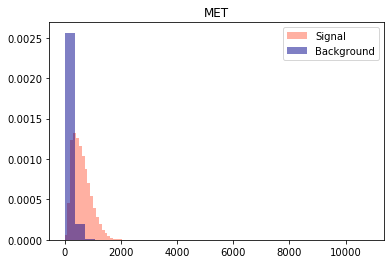

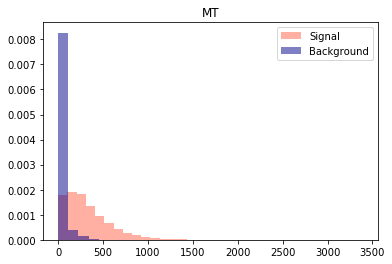

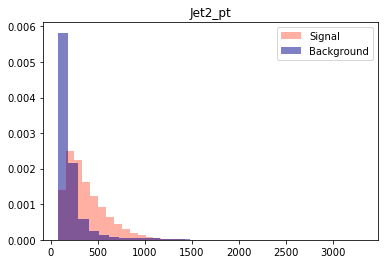

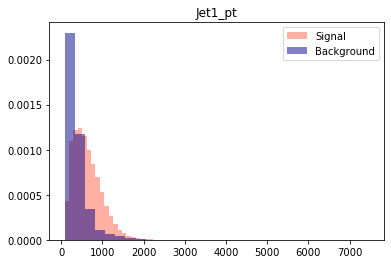

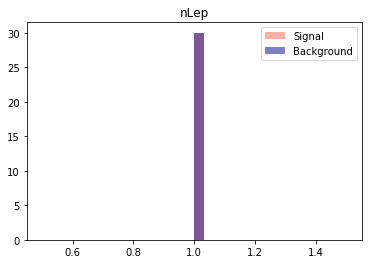

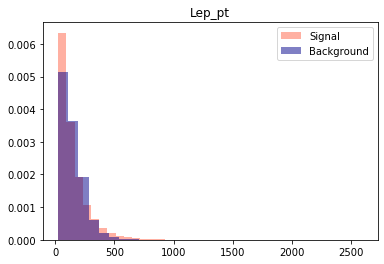

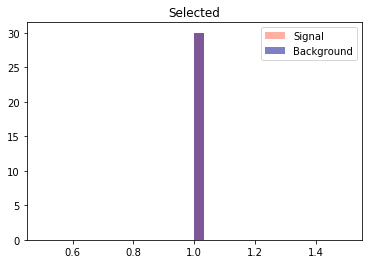

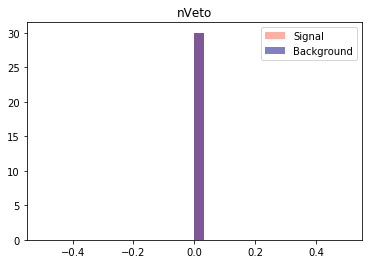

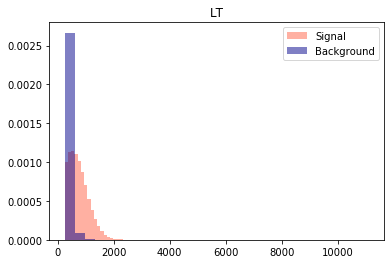

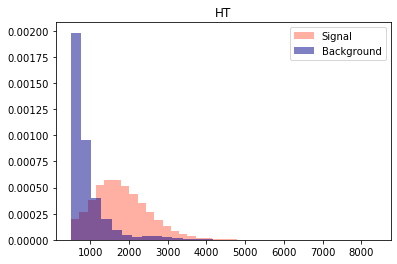

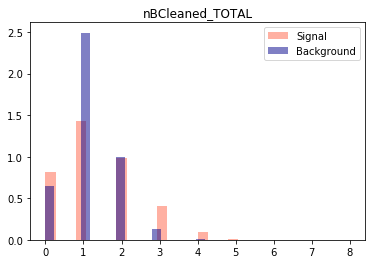

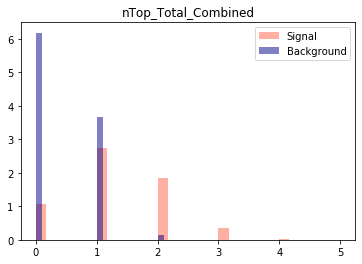

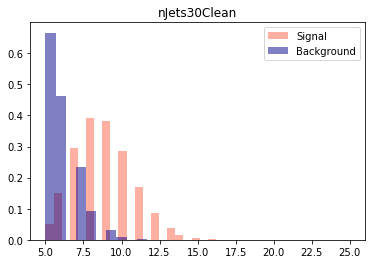

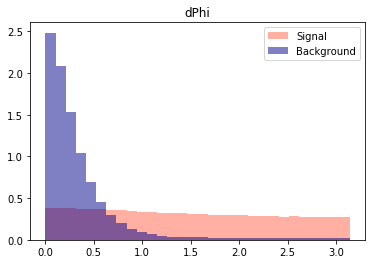

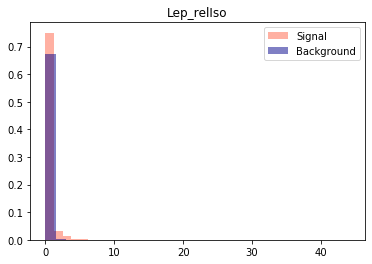

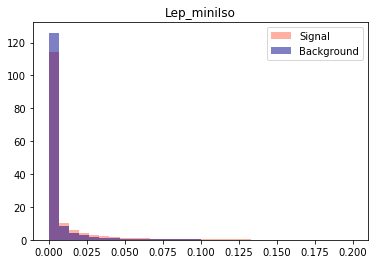

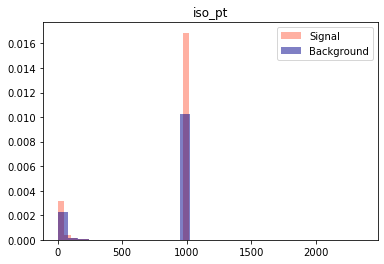

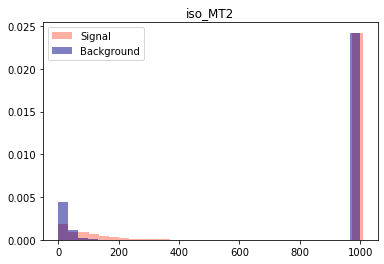

In [5]:
###Didn't do much in this part -> Check if it is okay
for feature in features:
    fig, ax = plt.subplots()
    _ = ax.hist(df.query('Y==1')[feature], bins=30, alpha=0.5, density=True, color='tomato', label='Signal')
    _ = ax.hist(df.query('Y==0')[feature], bins=30, alpha=0.5, density=True, color='darkblue', label='Background')
    ax.set_title(feature)
    ax.legend(loc='best')

Done with training


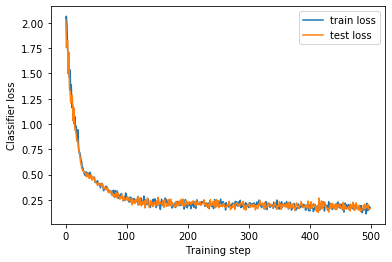

In [6]:

###Evaluating the training of the normal NN
clf_hbb = normal_training(generate_hbb, 500)


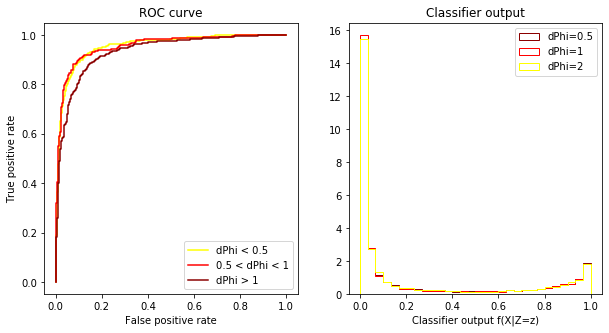

In [9]:

###Drawing plots to evaluate the effeciency of the NN
evaluate_hbb_classifier(clf_hbb, generate_hbb)


shape of tensor X is  18
Done with training


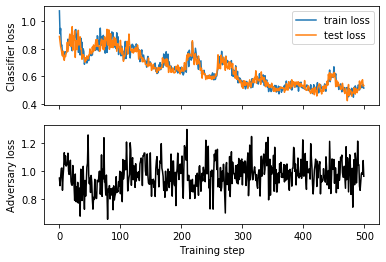

In [11]:

###Evaluating the training of the adversarial NN
clf_hbb_adv = adversarial_training(generate_hbb, 500)


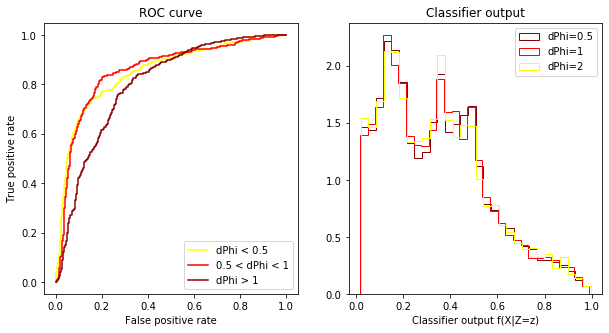

In [12]:

###Drawing plots to evaluate the effeciency of the adversarial NN
evaluate_hbb_classifier(clf_hbb_adv, generate_hbb)
